<a href="https://colab.research.google.com/github/Gioalf/AH2179/blob/main/project/AIprojectGioAlf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PUBLIC TRANSPORT PROJECT
The project will be divided into two parts, in both cases I will create models that estimate the arrival delay at different stages of the trip:\
* **Part A** will have limited available data, it will be missing all the real time data such as `upstream_stop_delay`, `previous_bus_delay`, `previous_trip_travel_time`, and `travel_time_for_previous_section`

* **Part B** will have all the available data that will lead to a more accurate prediction.

### METHOD
I will use different methods to create prediction models and obtain the best predictions possible, I will then likely use the best model I can get to predict the delays and then check the accuracy of them.\
I can also maybe do some feature engineering and use day of the week and stuff like that.

## DATA HANDLING
Here I will import the dataset and clean it to make it easier to use for my purposes

In [55]:
import pandas as pd
import numpy as np
import pandasql
from pandasql import sqldf

url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/ProjectAssignmentData/Dataset-PT.csv'
df = pd.read_csv(url, skiprows=1, header=0)

display(df.head())

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(weather)Rain,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,0,0,1,0,1,0,0,1
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,0,0,1,0,1,0,0,1
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,0,0,1,0,1,0,0,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,0,0,1,0,1,0,0,1
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,0,0,1,0,1,0,0,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 31 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Calendar_date                      545103 non-null  int64  
 1   route_id                           545103 non-null  int64  
 2   bus_id                             545103 non-null  int64  
 3   stop_sequence                      545103 non-null  int64  
 4   arrival_delay                      545103 non-null  int64  
 5   dwell_time                         545103 non-null  int64  
 6   travel_time_for_previous_section   545103 non-null  int64  
 7   scheduled_travel_time              545103 non-null  int64  
 8   upstream_stop_delay                545103 non-null  int64  
 9   origin_delay                       545103 non-null  int64  
 10  previous_bus_delay                 545103 non-null  int64  
 11  previous_trip_travel_time          5451

I noticed that with the current data I can't associate each row with a specific trip but only with a date and vehicle, so I will add that feature in the most trivial way by just adding a column with a sequential number for each trip.

In [59]:
def trip_counter(group):
    # create a counter that increases every 27 rows
    n_rows = len(group)
    group['trip_number'] = np.arange(n_rows) // 27 + 1
    return group

df = df.groupby('Calendar_date').apply(trip_counter).reset_index(drop=True)

/tmp/ipython-input-3494565459.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Calendar_date').apply(trip_counter).reset_index(drop=True)


In [60]:
df

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,trip_number
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,0,1,0,1,0,0,1,1
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,0,1,0,1,0,0,1,1
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,0,1,0,1,0,0,1,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,0,1,0,1,0,0,1,1
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,0,1,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545098,20220630,4,41362,23,344,13,74,44,341,12,...,0,0,0,1,1,0,0,0,1,50
545099,20220630,4,41362,24,330,15,34,92,344,12,...,0,0,0,1,1,0,0,0,1,50
545100,20220630,4,41362,25,339,17,63,43,330,12,...,0,0,0,1,1,0,0,0,1,50
545101,20220630,4,41362,26,331,0,35,58,339,12,...,0,0,0,1,1,0,0,0,1,50


In [67]:
# query = "SELECT DISTINCT Calendar_date, MAX(trip_number) FROM df GROUP BY Calendar_date"
# sqldf(query)

,Calendar_date,MAX(trip_number)
0,20220108,22
1,20220109,96
2,20220110,133
3,20220111,138
4,20220112,112
...,...,...
168,20220626,18
169,20220627,46
170,20220628,33
171,20220629,32


Trying to get some insights and ideas from the data I have

Average Arrival Delay by Stop Sequence:


,stop_sequence,arrival_delay
0,1,63.961117
1,2,100.140274
2,3,92.829660
3,4,65.273961
4,5,107.407251
5,6,138.431671
6,7,128.251226
7,8,106.233593
8,9,136.354797
9,10,161.177473


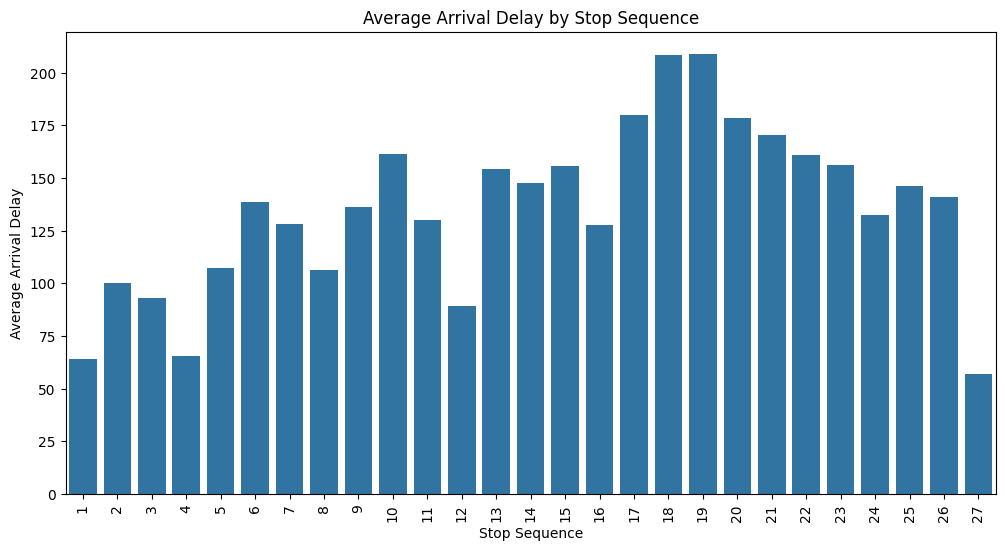

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average arrival delay for each stop sequence
average_delay_by_stop = df.groupby('stop_sequence')['arrival_delay'].mean().reset_index()

# Display the average arrival delay for each stop sequence
print("Average Arrival Delay by Stop Sequence:")
display(average_delay_by_stop)

# Optional: You can still visualize this data if you'd like, for example, with a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=average_delay_by_stop, x='stop_sequence', y='arrival_delay')
plt.title('Average Arrival Delay by Stop Sequence')
plt.xlabel('Stop Sequence')
plt.ylabel('Average Arrival Delay')
plt.xticks(rotation=90)
plt.show()

In [24]:
df.head(25)

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(weather)Rain,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,0,0,1,0,1,0,0,1
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,0,0,1,0,1,0,0,1
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,0,0,1,0,1,0,0,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,0,0,1,0,1,0,0,1
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,0,0,1,0,1,0,0,1
5,20220108,4,41344,6,260,13,105,38,242,100,...,0,0,0,0,1,0,1,0,0,1
6,20220108,4,41344,7,278,12,43,79,260,100,...,0,0,0,0,1,0,1,0,0,1
7,20220108,4,41344,8,272,8,85,97,278,100,...,0,0,0,0,1,0,1,0,0,1
8,20220108,4,41344,9,292,24,83,47,272,100,...,0,0,0,0,1,0,1,0,0,1
9,20220108,4,41344,10,351,9,43,85,292,100,...,0,0,0,0,1,0,1,0,0,1


Average Arrival Delay by Stop Sequence and Time of Day:


,stop_sequence,time_of_day,arrival_delay
0,1,AP,54.393781
1,1,MP,34.141484
2,1,OP,74.997470
3,2,AP,93.186565
4,2,MP,61.530490
...,...,...,...
76,26,MP,106.254130
77,26,OP,172.395983
78,27,AP,-23.506765
79,27,MP,19.576449


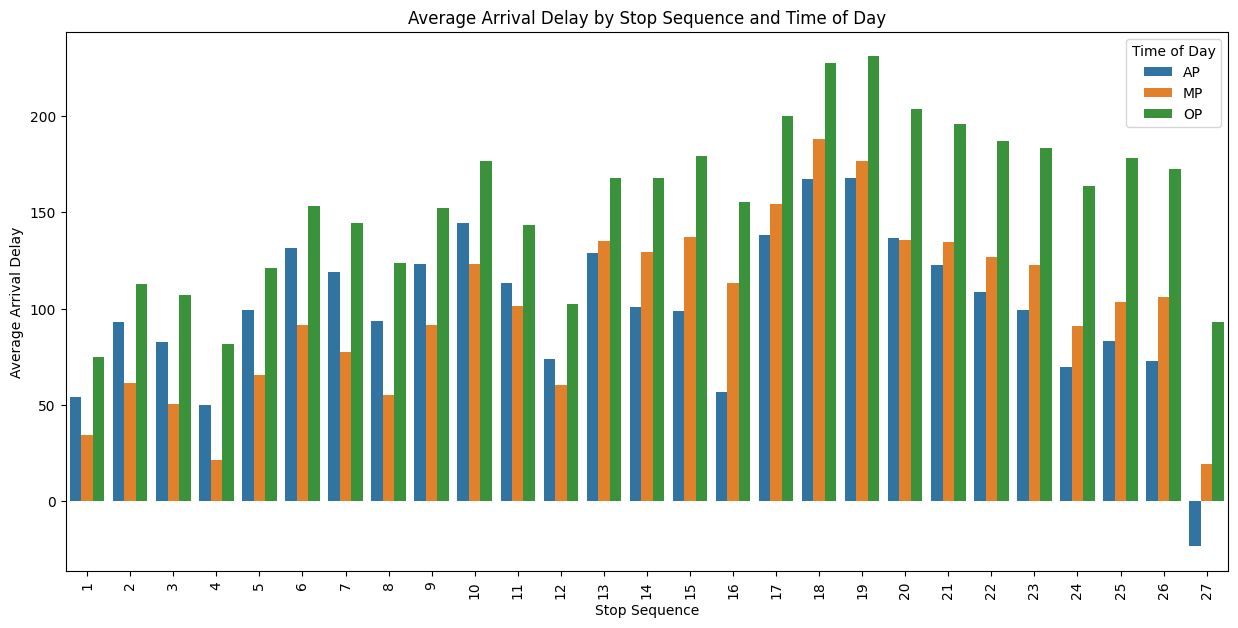

In [6]:
# Calculate the average arrival delay for each stop sequence and time of day
average_delay_by_stop_and_time = df.groupby(['stop_sequence', 'time_of_day'])['arrival_delay'].mean().reset_index()

# Display the average arrival delay by stop sequence and time of day
print("Average Arrival Delay by Stop Sequence and Time of Day:")
display(average_delay_by_stop_and_time)

# Visualize the average arrival delay by stop sequence and time of day using a grouped bar plot
plt.figure(figsize=(15, 7))
sns.barplot(data=average_delay_by_stop_and_time, x='stop_sequence', y='arrival_delay', hue='time_of_day')
plt.title('Average Arrival Delay by Stop Sequence and Time of Day')
plt.xlabel('Stop Sequence')
plt.ylabel('Average Arrival Delay')
plt.xticks(rotation=90)
plt.legend(title='Time of Day')
plt.show()

In [7]:
# Calculate the average arrival delay for each stop sequence and time of day first
average_delay_by_stop_and_time = df.groupby(['stop_sequence', 'time_of_day'])['arrival_delay'].mean().reset_index()

# Now calculate the standard deviation of these average delays for each stop sequence
std_of_average_delay_by_stop = average_delay_by_stop_and_time.groupby('stop_sequence')['arrival_delay'].std().reset_index()

# Display the standard deviation of the average arrival delay by stop sequence
print("Standard Deviation of Average Arrival Delay Across Time of Day for Each Stop Sequence:")
display(std_of_average_delay_by_stop)

Standard Deviation of Average Arrival Delay Across Time of Day for Each Stop Sequence:


,stop_sequence,arrival_delay
0,1,20.428245
1,2,25.787169
2,3,28.469313
3,4,30.210727
4,5,27.900489
5,6,31.228323
6,7,34.022809
7,8,34.500700
8,9,30.368215
9,10,26.782627


## PART A
I will get rid of some of the features that are only available in real time, i.e: `upstream_stop_delay`, `previous_bus_delay`, `previous_trip_travel_time`, `recurrent_delay`, and `travel_time_for_previous_section`

In [8]:
dfA=df.drop(['upstream_stop_delay', 'previous_bus_delay', 'previous_trip_travel_time', 'recurrent_delay', 'travel_time_for_previous_section'], axis=1)

In [9]:
dfA

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,scheduled_travel_time,origin_delay,traffic_condition,weather,...,factor(weather)Rain,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak
0,20220108,4,41344,1,151,0,120,100,168.666667,Light Snow,...,0,0,0,0,1,0,1,0,0,1
1,20220108,4,41344,2,185,24,45,100,46.333333,Light Snow,...,0,0,0,0,1,0,1,0,0,1
2,20220108,4,41344,3,186,0,41,100,36.666667,Light Snow,...,0,0,0,0,1,0,1,0,0,1
3,20220108,4,41344,4,202,12,94,100,88.000000,Light Snow,...,0,0,0,0,1,0,1,0,0,1
4,20220108,4,41344,5,242,21,86,100,102.000000,Light Snow,...,0,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545098,20220630,4,41362,23,344,13,44,12,32.666667,Normal,...,0,0,0,0,1,1,0,0,0,1
545099,20220630,4,41362,24,330,15,92,12,77.000000,Normal,...,0,0,0,0,1,1,0,0,0,1
545100,20220630,4,41362,25,339,17,43,12,38.000000,Normal,...,0,0,0,0,1,1,0,0,0,1
545101,20220630,4,41362,26,331,0,58,12,50.666667,Normal,...,0,0,0,0,1,1,0,0,0,1


### FIRST MODEL

In this model I will try to do a linear regression on the whole dataset to see what comes out.\
I will add the arrival delay at stop 20 of each run to every row of that run to be used as the target.\
I assume this will perform poorly as it is a huge training of the whole dataset and I will test it from specific stop numbers. I'm not even sure it will run, and also I think it might leak data since I use delays from stops that are further away.

In [33]:
dfA.groupby(['Calendar_date', 'bus_id']).size().reset_index(name='count')

,Calendar_date,bus_id,count
0,20220108,41344,81
1,20220108,41353,54
2,20220108,41358,54
3,20220108,41360,54
4,20220108,41362,27
...,...,...,...
4108,20220630,44418,81
4109,20220630,45529,27
4110,20220630,45536,54
4111,20220630,45711,81


In [32]:
dfA_clean=dfA.copy()

# Filter for rows where stop_sequence is 20
delay_at_stop_20 = dfA_clean[dfA_clean['stop_sequence'] == 20][['Calendar_date', 'trip_number', 'arrival_delay']]

# Rename the 'arrival_delay' column to indicate it's the delay at stop 20
delay_at_stop_20 = delay_at_stop_20.rename(columns={'arrival_delay': 'arrival_delay_stop_20'})

# Merge this information back into dfA_clean
dfA_clean = pd.merge(dfA_clean, delay_at_stop_20, on=['Calendar_date', 'bus_id'], how='left')

# Display the updated DataFrame
dfA_clean.head(30)


# dfA_clean=dfA_clean.drop(['route_id', 'weather', 'temperature', 'day_of_week',
#        'time_of_day'], axis=1)

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,scheduled_travel_time,origin_delay,traffic_condition,weather,...,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,arrival_delay_stop_20
0,20220108,4,41344,1,151,0,120,100,168.666667,Light Snow,...,0,0,0,1,0,1,0,0,1,419
1,20220108,4,41344,1,151,0,120,100,168.666667,Light Snow,...,0,0,0,1,0,1,0,0,1,280
2,20220108,4,41344,1,151,0,120,100,168.666667,Light Snow,...,0,0,0,1,0,1,0,0,1,105
3,20220108,4,41344,2,185,24,45,100,46.333333,Light Snow,...,0,0,0,1,0,1,0,0,1,419
4,20220108,4,41344,2,185,24,45,100,46.333333,Light Snow,...,0,0,0,1,0,1,0,0,1,280
5,20220108,4,41344,2,185,24,45,100,46.333333,Light Snow,...,0,0,0,1,0,1,0,0,1,105
6,20220108,4,41344,3,186,0,41,100,36.666667,Light Snow,...,0,0,0,1,0,1,0,0,1,419
7,20220108,4,41344,3,186,0,41,100,36.666667,Light Snow,...,0,0,0,1,0,1,0,0,1,280
8,20220108,4,41344,3,186,0,41,100,36.666667,Light Snow,...,0,0,0,1,0,1,0,0,1,105
9,20220108,4,41344,4,202,12,94,100,88.000000,Light Snow,...,0,0,0,1,0,1,0,0,1,419


In [16]:
dfA_clean

,Calendar_date,bus_id,stop_sequence,arrival_delay,dwell_time,scheduled_travel_time,origin_delay,traffic_condition,factor(weather)Light_Rain,factor(weather)Light_Snow,...,factor(weather)Rain,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak
0,20220108,41344,1,151,0,120,100,168.666667,0,1,...,0,0,0,0,1,0,1,0,0,1
1,20220108,41344,2,185,24,45,100,46.333333,0,1,...,0,0,0,0,1,0,1,0,0,1
2,20220108,41344,3,186,0,41,100,36.666667,0,1,...,0,0,0,0,1,0,1,0,0,1
3,20220108,41344,4,202,12,94,100,88.000000,0,1,...,0,0,0,0,1,0,1,0,0,1
4,20220108,41344,5,242,21,86,100,102.000000,0,1,...,0,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545098,20220630,41362,23,344,13,44,12,32.666667,0,0,...,0,0,0,0,1,1,0,0,0,1
545099,20220630,41362,24,330,15,92,12,77.000000,0,0,...,0,0,0,0,1,1,0,0,0,1
545100,20220630,41362,25,339,17,43,12,38.000000,0,0,...,0,0,0,0,1,1,0,0,0,1
545101,20220630,41362,26,331,0,58,12,50.666667,0,0,...,0,0,0,0,1,1,0,0,0,1
